In [1]:
import json
import math
import clingo
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from itertools import batched

DATA_FILE = '../Data_Extreme_Solar/daily_01_2024-01-01.json'
SCHEDULER_SOURCE = '../Source/schedule_discrete.lp'

# This context class allows defining utility methods in Python to be called in the ASP code
class Context:
	def clamp(self, x, lower, upper):
		return min(max(x, lower), upper)
	
	def max(self, a, b):
		return max(a, b)
	
	def min(self, a, b):
		return min(a, b)

# Read model inputs from data file
with open(DATA_FILE) as f:
	data = json.load(f)

# Read base model source
with open(SCHEDULER_SOURCE) as f:
	scheduler_program = f.read()


# Function that prints model output
def print_model(model):
	atoms = model.symbols(shown=True)
	grouped = {}

	# group atoms by predicate name
	for atom in atoms:
		grouped.setdefault(atom.name, []).append(atom)

	# print neatly grouped
	for pred in grouped.keys():
		print(f"% {pred} facts:")
		for fact in sorted(grouped[pred]):
			print(f"  {fact}")
		print()

# Function that prints model summary to track optimization process
def summarize_model(model):
	print(f'[{datetime.now().strftime("%H:%M:%S")}] Found model #{model.number} with cost {model.cost}; Optimal: {model.optimality_proven}')

# Add in facts from data file
#
# Note that we just generate ASP code to pass to Clingo. It should be possible to pass symbolic constructs
# instead to prevent the string format/parse pass, but the API for that is a bit finicky. So this works as well.
#
# Also note that we are enumerating two slots in a batch. This is to convert from 30 minute slots to 1 hour slots.
# This is to reduce computational complexity.
program_input = ''
batch_count = 4
for (hour, slots) in enumerate(batched(data['schedule_input'], n=batch_count)):
	slot_count = len(slots)

	# Average price between slots, in tenth of cents
	price = sum((slot['price_buying'] * 1000 for slot in slots)) / slot_count

	# Production and consumption are in Wh, not in W. So we use the sum
	production_ac = sum((slot['production_forecast_ac'] for slot in slots))
	production_dc = sum((slot['production_forecast_dc'] for slot in slots))
	consumption = sum((slot['consumption_forecast'] for slot in slots))

	# Output all the atoms as string values in the ASP language
	program_input += f'price({hour + 1}, {round(price)}).\n'
	program_input += f'production({hour + 1}, {round(production_ac + production_dc)}).\n'
	program_input += f'consumption({hour + 1}, {round(consumption)}).\n'

hours = math.ceil(len(data['schedule_input']) / batch_count)

# Put all the constants we want to input in a dict for easy mapping to strings
site = data['site_info']
constants = \
{
	'hours': hours,
	'max_charge_rate': site['max_charge_amount'] * batch_count * 100 / site['battery_capacity'],
	'max_discharge_rate': site['max_discharge_amount'] * batch_count * 100 / site['battery_capacity'],
	'charge_efficiency': site['charge_efficiency_from_ac'] * 100,
	'discharge_efficiency': site['discharge_efficiency_to_ac'] * 100,
}

# Construct command-line parameters as a list of strings
parameters = \
[ 
	# Extra parameters for Clingo
	'--stats', 
	'--parallel-mode', '4',

	# Create -c flag and key=value format for each constant
	*[ s for (key, value) in constants.items() for s in [ '-c', f'{key}={round(value)}' ] ],
]

ctl = clingo.Control(parameters)

print(f'Composite input:')
print(program_input)
print()

# Construct the model from base program + input
print(f'Constructing model...')
ctl.add("input", [], program_input)
ctl.add("base", [], scheduler_program)

# Ground the model
print(f'Grounding model...')
ctl.ground([("input", []), ("base", [ ])], context=Context())

# And solve it
print(f'Starting solve...')
result = ctl.solve(on_model=summarize_model, on_last=print_model)

print(f'Solving result: {result}')
print('Stats:')
print(f'Atoms: {ctl.statistics['problem']['lp']['atoms']}')
print(f'Rules: {ctl.statistics['problem']['lp']['rules']}')
print(f'Choices: {ctl.statistics['solving']['solvers']['choices']}')
print(f'Total time: {ctl.statistics['summary']['times']['total']:.2f}s')

import matplotlib.pyplot as plt
# Containers for results
results = {
    "schedule": {},
    "soc": {},
    "grid_usage": {},
    "price": {},
    "cost": {}
}

def collect_model(model):
    atoms = model.symbols(shown=True)
    for atom in atoms:
        name = atom.name
        args = atom.arguments
        if name in results and len(args) == 2:
            h = int(str(args[0]))
            v = str(args[1])
            if v.lstrip('-').isdigit():
                v = int(v)
            results[name][h] = v

# Run solver with this callback
ctl.solve(on_last=collect_model)

# --- Prepare data for plotting ---
# Collect hours from soc, skip hour 0 (initial state)
hours = sorted(results["soc"].keys())
hours = [h for h in hours if h > 0]

# Build lists, casting to int for plotting
soc = [int(results["soc"][h]) for h in hours]
grid_usage = [int(results["grid_usage"].get(h, 0)) for h in hours]
price = [int(results["price"].get(h, 0)) for h in hours]
cost = [int(results["cost"].get(h, 0)) for h in hours]
schedule = [results["schedule"].get(h, "idle") for h in hours]



Composite input:
price(1, 30).
production(1, 12000).
consumption(1, 500).
price(2, 26).
production(2, 12000).
consumption(2, 500).
price(3, 13).
production(3, 12000).
consumption(3, 500).
price(4, 61).
production(4, 12000).
consumption(4, 500).
price(5, 79).
production(5, 12000).
consumption(5, 2300).
price(6, 90).
production(6, 12000).
consumption(6, 4100).
price(7, 122).
production(7, 12000).
consumption(7, 800).
price(8, 131).
production(8, 12000).
consumption(8, 500).
price(9, 133).
production(9, 12000).
consumption(9, 500).
price(10, 92).
production(10, 12000).
consumption(10, 500).
price(11, 74).
production(11, 12000).
consumption(11, 500).
price(12, 65).
production(12, 12000).
consumption(12, 500).


Constructing model...
Grounding model...
Starting solve...
[16:34:36] Found model #1 with cost [-10032669]; Optimal: False
[16:34:36] Found model #2 with cost [-10033805]; Optimal: False
[16:34:36] Found model #3 with cost [-10033947]; Optimal: False
[16:34:36] Found model #4 with c

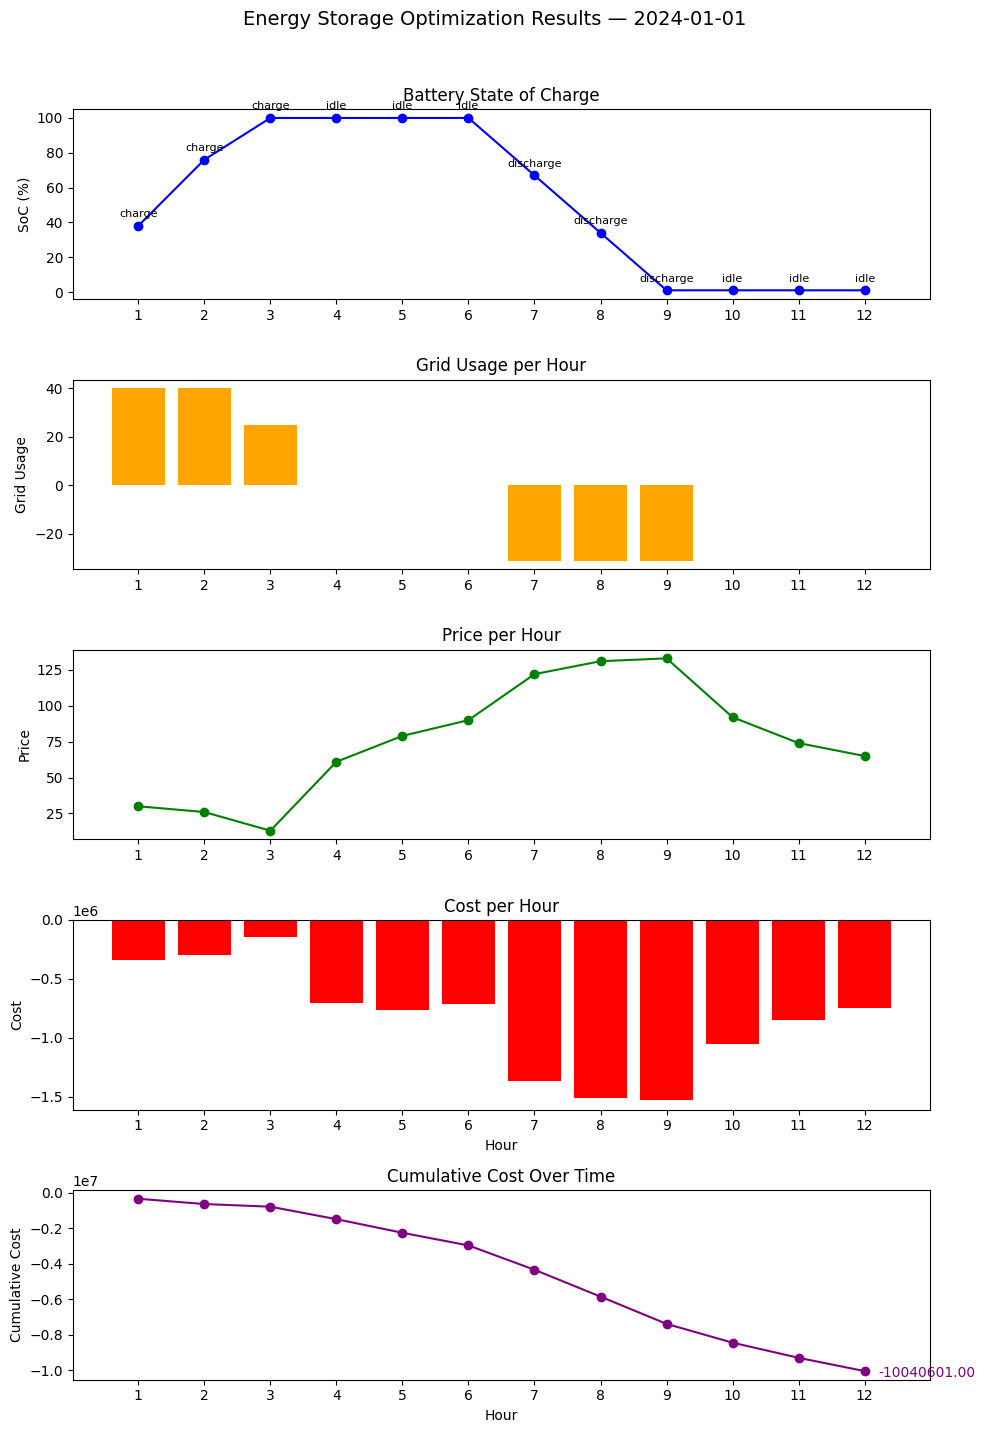

Total Cumulative Cost: -10040601.00


In [ ]:
# --- Parse date from filename ---
filename = os.path.basename(DATA_FILE)
plot_date = filename.split("_")[-1].replace(".json", "")

# --- Plot ---
fig, axs = plt.subplots(5, 1, figsize=(10, 14), sharex=True)

# Add a global title with the date
fig.suptitle(f"Energy Storage Optimization Results — {plot_date}", fontsize=14, y=1.02)

# 1. SoC line plot
axs[0].plot(hours, soc, marker='o', color='blue')
axs[0].set_ylabel("SoC (%)")
axs[0].set_title("Battery State of Charge")
for h, action in zip(hours, schedule):
    axs[0].text(h, soc[hours.index(h)] + 5, action, ha='center', fontsize=8)

# 2. Grid usage bar plot
axs[1].bar(hours, grid_usage, color='orange')
axs[1].set_ylabel("Grid Usage")
axs[1].set_title("Grid Usage per Hour")

# 3. Price line plot
axs[2].plot(hours, price, marker='o', color='green')
axs[2].set_ylabel("Price")
axs[2].set_title("Price per Hour")

# 4. Cost bar plot
axs[3].bar(hours, cost, color='red')
axs[3].set_ylabel("Cost")
axs[3].set_title("Cost per Hour")
axs[3].set_xlabel("Hour")

# 5. Cumulative cost line plot
cumulative_cost_series = np.cumsum(cost)
axs[4].plot(hours, cumulative_cost_series, marker='o', color='purple')
axs[4].set_ylabel("Cumulative Cost")
axs[4].set_title("Cumulative Cost Over Time")
axs[4].set_xlabel("Hour")

# Annotate final cumulative cost (shifted higher and more to the right)
axs[4].text(hours[-1] + 0.2,                # move 0.2 units to the right
            cumulative_cost_series[-1] * 1.05,  # place slightly above the last value
            f"{cumulative_cost_series[-1]:.2f}",
            ha='left', va='bottom', fontsize=10, color='purple')

# Add hour ticks to all plots
for ax in axs:
    ax.set_xticks(hours)
    ax.set_xticklabels(hours)
    ax.tick_params(labelbottom=True)  # <-- force labels to show on all subplots

plt.tight_layout()
plt.show()

# --- Print total cumulative cost ---
total_cost = cumulative_cost_series[-1]
print(f"Total Cumulative Cost: {total_cost:.2f}")